In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(42)
torch.manual_seed(42)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA on GPU:", torch.cuda.get_device_name(0))
# elif torch.backends.mps.is_available():  # Only on MacOS
#     device = torch.device("mps")
#     print("Using MPS (Metal Performance Shaders)")
# else:
#     device = torch.device("cpu")
#     print("Using CPU")


device = 'cpu'
print("Selected device:", device)

Selected device: cpu


In [3]:
df = pd.read_csv("spams.csv")
print(df.shape)
df.head()

(5572, 2)


,data,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
# Train / Test split

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=.2)
df_train.shape, df_test.shape

((4457, 2), (1115, 2))

In [5]:
df_train.head()

,data,label
1978,No I'm in the same boat. Still here at my moms...,0
3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,1
3935,They r giving a second chance to rahul dengra.,0
4078,O i played smash bros &lt;#&gt; religiously.,0
4086,PRIVATE! Your 2003 Account Statement for 07973...,1


In [6]:
import re
word = "$%Hi98"
word = word.lower()

# word.replace(x, y)("$","")
# Read about re in Python

re.sub("[^a-z0-9]","", word)

# re.sub("[^A-Za-z0-9]","", word)

'hi98'

In [7]:
def clean_word(word):
    return re.sub("[^a-z0-9]","", word.lower())

In [8]:
# 
words = " ".join(df_train["data"].values).split()
words = [clean_word(w) for w in words]
words = list(filter(None, words))
words = np.unique(words)
len(words)

8376

In [9]:
# word2idx dictionary
word2idx = {}
word2idx[""] = 0
for i,w in enumerate(words):
    word2idx[w] = i+1

len(word2idx)

8377

In [10]:
# Convert sent to inds
in_ = df_train.iloc[0,0]

def sent2inds(in_):
    in_ = in_.split()

    out_ = []

    for w in in_:
        w = clean_word(w)
        if w != "" and w in word2idx.keys():
            out_.append(word2idx[w])
    return out_

In [11]:
df_train["data_encoded"] = df_train["data"].apply(sent2inds)

In [12]:
df_train.head()

,data,label,data_encoded
1978,No I'm in the same boat. Still here at my moms...,0,"[5136, 3874, 3896, 7305, 6331, 1517, 6953, 363..."
3989,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,1,"[1311, 5268, 3437, 4012, 6998, 2911, 5602, 312..."
3935,They r giving a second chance to rahul dengra.,0,"[7333, 5961, 3346, 815, 6411, 1857, 7434, 5970..."
4078,O i played smash bros &lt;#&gt; religiously.,0,"[5249, 3830, 5647, 6694, 1626, 4555, 6111]"
4086,PRIVATE! Your 2003 Account Statement for 07973...,1,"[5835, 8339, 371, 858, 6924, 3129, 42, 6578, 6..."


In [13]:
X_train = df_train["data_encoded"].values

In [14]:
# 0 padding to have the same lengths inputs

In [15]:
from itertools import zip_longest
# Go and check documention of this function
X_train = np.array(list(zip_longest(*X_train, fillvalue = 0))).T
X_train.shape

(4457, 115)

In [16]:
y_train = df_train["label"].values
y_train.shape

(4457,)

In [17]:
# Dataset

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).long()
        self.labels = torch.from_numpy(labels).float()
        
    def __getitem__(self, index):
        return (self.data[index], self.labels[index])

    def __len__(self):
        return len(self.data)
    
train_dataset = MyDataset(X_train, y_train)

In [18]:
# Train / valid
train_dataset, val_dataset = random_split(train_dataset, [4000, 457])

len(train_dataset), len(val_dataset) # after train/val split

(4000, 457)

In [19]:
# dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [21]:
# model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.emb = nn.Embedding(len(word2idx), 50)
        self.rnn = nn.RNN(input_size=50, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32,1)

    
    def forward(self, x):
        
        out = self.emb(x)
        h0 = torch.zeros(1, x.size(0), 32)
        outs, hidden = self.rnn(out)
        # out = outs[:,-1,:]
        
        # out = torch.max(outs, 1)
        out, _ = torch.max(outs, 1)

        out  = self.fc(out)
        return out
    
tmpModel = MyModel()
tmpBatch,_ = next(iter(train_loader))
tmpOut = tmpModel(tmpBatch)
tmpOut.shape

torch.Size([16, 1])

In [26]:
# model training

# Model training

model = MyModel().to(device)

print(model.state_dict())

train_losses = [] # To track the training loss
validation_losses = [] # To track the validation loss

lr = 1e-1
n_epochs = 10

loss_fn = nn.BCEWithLogitsLoss()  #####
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train() 
    train_loss = 0
    
    for x_batch, y_batch in train_loader: # The mini batches loop for train
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).squeeze()
        
        yhat = model(x_batch)
        yhat = yhat.view(-1)
        loss = loss_fn(yhat, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss) # keep tracking of the losses
    
    # Validation Loop
    model.eval()
    validation_loss = 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader: # The mini batches loop for validation

            x_val = x_val.to(device)
            y_val = y_val.to(device).squeeze()

            yhat = model(x_val)
            yhat = yhat.view(-1)
            val_loss = loss_fn(y_val, yhat)
            
            validation_loss += val_loss.item()
    
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss) # keep tracking of the losses
    
print(model.state_dict())

OrderedDict([('emb.weight', tensor([[ 0.3688,  1.8552,  0.4729,  ..., -1.4277, -1.1662,  1.0935],
        [ 0.9693, -1.6308,  0.4671,  ...,  1.6205, -0.7875,  0.4961],
        [ 1.3797,  0.3807,  1.4968,  ...,  0.1529,  0.1963, -1.3197],
        ...,
        [-1.1947, -0.9787,  1.5151,  ...,  0.0206, -0.5626,  1.1663],
        [-1.0670,  1.3358, -0.8704,  ...,  1.8087,  0.6697, -0.7110],
        [-0.6183, -0.2372,  0.9144,  ..., -1.6363,  0.0275,  0.3009]])), ('rnn.weight_ih_l0', tensor([[-0.1335, -0.0174,  0.1490,  ..., -0.0217, -0.0640,  0.0276],
        [-0.0187, -0.0743, -0.1041,  ...,  0.0411,  0.1066, -0.1645],
        [-0.0441, -0.1665,  0.0655,  ..., -0.0879,  0.0217,  0.1455],
        ...,
        [-0.1363, -0.1621,  0.1652,  ..., -0.0663,  0.0597, -0.0041],
        [ 0.1079,  0.1657,  0.1227,  ...,  0.0461,  0.0538,  0.1536],
        [-0.1350,  0.1213,  0.0511,  ...,  0.0974, -0.0397, -0.0164]])), ('rnn.weight_hh_l0', tensor([[-0.1440,  0.0655,  0.1081,  ...,  0.0941, -0.1115

NameError: name 'X_test' is not defined

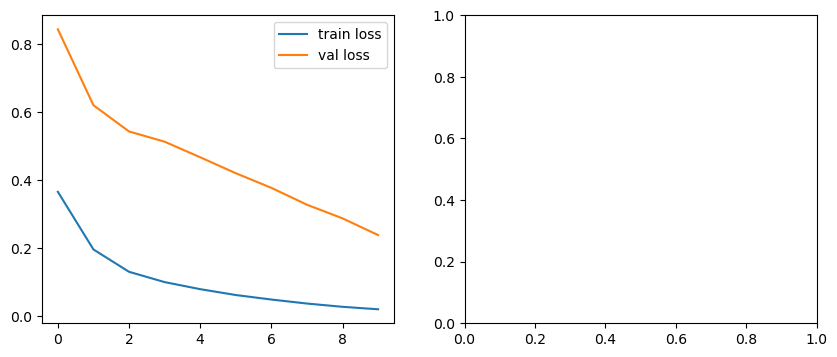

In [28]:
# # Evauation

# fig, ax = plt.subplots(1,2, figsize=(10,4))
# ax[0].plot(train_losses,  label="train loss"); 
# ax[0].plot(validation_losses,  label="val loss"); 
# ax[0].legend();


# y_pred = model( torch.from_numpy(X_test).float().to(device) )
# y_pred = y_pred.detach().numpy()
# plt.plot(y_test,c='b')
# plt.plot(y_pred,c='r')
# plt.legend()